# **Capstone Project: Partner Grading**

## File 1 - EDA Data

# Statement

- Backgroud
  * Partner is an important part to reach customers. Help distribute products to the area well. And help reduce investment in setting up a store. The partner who comes as a partnership will receive a profit in many forms, such as operating fees, commission or extra reward when hit the target, with such benefits, there are some partners focus on selling out in large quantities. But low quality of customers for example customer not pay for the invoice, Customers who only use freebies, when they run out, come back to buy again.This type of customer causes the company to lose income.

  * Partner grading s therefore a part that allows to help team to monitor and troubleshoot problem in a time.


- Problem Statement
  * The partner's grade arrangement is a manual operation and relies on data. Now they use unpaid bill in 1 month previous . And is working on Microsoft Excel.
  * The current Commission process cannot be used to determine Commission tier because it is a manual process. Lack of reliability.
  * Evaluation of efficiency and quality of Partner slowness.
  * The company loses revenue from customers that is not quality.

- Business Benefit:
  * Help the team can solve or judge partner that has a risk.
  * Helps company reduce excessive expense.
  * Limited some offer that partner get example reduce giving discount offer to customer, limited quantity of products has allocate to partner

> Cost : expense per partner = 15,000 ฿

>Gain/Loss price = 600฿ * 4 mth = 2,400 ฿ per subs

- Limitation:
  * data churn has a lot of zero value (it's good), make quantile mistake

- The process of making a project
  * backgroup & problem statement
  * query data
  * eda
  * RMF by using value of recency, sales, churn (for basic)
    - but from limitation, will add gridsearch cv to find the best quantile for RFM 
  * model
    - classification : to create partner grade/group
    - ARIMA : for predict sales performance (Addon)


- Data Dict

| field | description | Type |
|-------|-------------|------|
| partner_code | staff code all sales channel | string |
| sales_date | date of subscriber start | datetime |
| total | number of new subscriber | int |
| revenue | total of revenue | int |
| churn | total of subscriber leave | int |


# Import Module

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyoff
import plotly.express as px

import datetime as dt
from datetime import datetime as dt2
from datetime import timedelta as td
from datetime import time as tm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,cross_validate


# Import Data

In [2]:
import pandas as pd
df = pd.read_csv('data_partner_sales.txt',delimiter='|')

# ข้อมูลหลักจากระบบ ข้อมูลจาก partner code ประกอบด้วย ขาย,รายได้, disconnct, partner

In [3]:
df.head(5)

,PARTNER_CODE,PREFIX,PARTNER_STATUS,PROVINCE_ENG,DISTRICT_EN,SUB_DISTRICT_EN,SALES_DATE,REGISTER_DATE,TM_KEY_DAY,TOTAL,REVENUE,CHURN,AGING,PAID,NO_PAID,GAIN,LOSS,PARTNER_AGING
0,10033382,10,Non-Active,Roi Et,Selaphum,Phon Sawan,2021-01-07 00:00:00.000000000,2018-05-21 00:00:00.000000000,20210107,5,2630.0,0,0,36,0,24875,0,2038.0
1,39072751,39,Active,Bangkok,Lat Phrao,Lat Phrao,2021-01-11 00:00:00.000000000,2020-08-27 00:00:00.000000000,20210111,1,459.0,0,0,12,0,5464,0,1209.0
2,39048706,39,Active,Unidentified,Unidentified,Unidentified,2021-01-11 00:00:00.000000000,2018-05-02 00:00:00.000000000,20210111,16,6031.0,0,0,128,16,76487,6724,2057.0
3,39058351,39,Non-Active,Pathum Thani,Khlong Luang,Khlong Sam,2021-01-10 00:00:00.000000000,2019-09-24 00:00:00.000000000,20210110,2,918.0,1,1010,48,0,23043,0,1547.0
4,39056040,39,Active,Songkhla,Sathing Phra,Chathing Phra,2021-01-08 00:00:00.000000000,2019-08-29 00:00:00.000000000,20210108,2,1132.0,0,0,12,0,7733,0,1573.0


## EDA

In [4]:
# Create Date series เปลี่ยนวันที่ sales_date ให้อยู่ในรูป date format
df['Date'] = pd.to_datetime(df['SALES_DATE'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['year_month'] = df['Date'].apply(lambda x: x.strftime('%Y-%m'))
df.columns = df.columns.str.lower()

Check Max/Min of data

In [5]:
print(df["date"].min())
print(df["date"].max())

2021-01-02 00:00:00
2023-12-17 00:00:00


Total register partner in month

In [6]:
df_agg= df.groupby(["date","month","year"]).partner_code.count()
df_agg=pd.DataFrame(df_agg)
df_agg=df_agg.reset_index()
df_agg.head()

,date,month,year,partner_code
0,2021-01-02,1,2021,31
1,2021-01-03,1,2021,168
2,2021-01-04,1,2021,594
3,2021-01-05,1,2021,1142
4,2021-01-06,1,2021,1461


### Seperate Dataframe for analyze

In [7]:
# create new dataframe with sum of price by year, month from original dataframe
df_sales = df.groupby(['year_month'])['total'].sum().reset_index()
df_revenue = df.groupby(['year_month'])['revenue'].sum().reset_index()
df_churn = df.groupby(['year_month'])['churn'].sum().reset_index()
df_partner = df.groupby(['year_month'])['total'].nunique().reset_index()
df_revenue.shape, df_sales.shape,df_partner.shape,df_churn.shape

((36, 2), (36, 2), (36, 2), (36, 2))

In [48]:
# Create function for plot chart
def line_plot(x_axis, y_axis, title, x_title, y_title):
    fig = px.line(x=x_axis, y=y_axis, title=title)
    fig.update_layout(
        autosize=False,
        width=900,
        height=200,
        template='plotly_dark',
        title=dict(x=0.5,font=dict(size=14, color='#FFFFFF')),
        xaxis_title=x_title,
        yaxis_title=y_title,
        font=dict(
            family="Courier New, monospace",
            size=10,
            color="#FFFFFF"
        ),
        plot_bgcolor='rgb(0, 0, 0)',
        xaxis=dict(tickfont=dict(size=10, color='#FFFFFF')),
        yaxis=dict(tickfont=dict(size=10, color='#FFFFFF')),
        legend=dict(x=0.1, y=1.1, orientation='h', font=dict(color='#FFFFFF')),
        margin=dict(l=10, r=10, t=40, b=40)
    )
    fig.show()

In [49]:
line_plot(df_sales['year_month'], df_sales['total'], 'Monthly New Sales (Subs)', 'Year-Month', 'New Sales (Subs)')
# จำนวนการขายใหม่ต่อเดือน

In [10]:
line_plot(df_revenue['year_month'], df_revenue['revenue'], 'Monthly New Revenue (฿)', 'Year-Month', 'New Revenue (฿)')
# รายได้ใหม่ต่อเดือน

Churn rate in each month

In [11]:
line_plot(df_churn['year_month'], df_churn['churn'], 'Monthly Churn (Subs)', 'Year-Month', 'Churn (Subs)')

Total partner has activity in each month

In [12]:
line_plot(df_partner['year_month'], df_partner['total'], 'Monthly Partner (Count)', 'Year-Month', 'Partner')

Create Day-1 variable

In [13]:
# gest system date -1
import datetime
import time
import calendar
import datetime as dt
from datetime import datetime as dt2
from datetime import timedelta as td
from datetime import time as tm

# get system date
today = datetime.date.today()
# get system date -1
yesterday = today - td(days=1)

print(f' Current day value: {today}')
print(f' Previous day value: {yesterday}')


 Current day value: 2023-12-21
 Previous day value: 2023-12-20


In [14]:
# Create System Data
today = datetime.date.today()
yesterday = today - td(days=1)
today = today.strftime('%Y-%m-%d')
yesterday = yesterday.strftime('%Y-%m-%d')

NOW = dt2.strptime(yesterday, '%Y-%m-%d').date()
df['Date'] = pd.DatetimeIndex(df.sales_date).date

Dataframe : sales recency all partner type
- compare max sales date and sysdate-1

recency formular
* max(salesdate) - yester date

In [15]:
df_recency = df.groupby(['partner_code'],as_index=False)['Date'].max()
df_recency.columns = ['partner_code','date']
df_recency['recency'] = df_recency.date.apply(lambda x:(NOW - x).days)
df_recency.drop(columns=['date'],inplace=True)
df_recency['partner_prefix'] = df_recency['partner_code'].astype(str).str[:3]
df_recency.head()


,partner_code,recency,partner_prefix
0,01001700,762,010
1,01003539,728,010
2,01003913,880,010
3,01004328,202,010
4,01004673,1067,010


Plot portion of recent sales by partner type

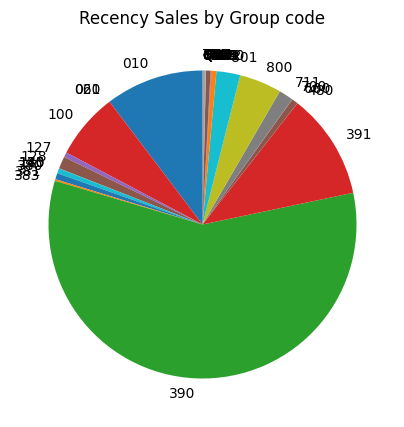

In [16]:
plt.figure(figsize=(5,5))
df_recency.groupby('partner_prefix')['recency'].sum().plot(kind='pie', startangle=90)
plt.title('Recency Sales by Group code')
plt.ylabel('')
plt.show()

create new recent sales dataframe of partner type Prefix in 39,80,10
- 39 : Direct Sales
- 80 : Retail Shop
- 10 : Retail Partner

In [17]:
df_recent_select = df_recency[df_recency['partner_prefix'].isin(['390','391','801','800','100'])]
df_recent_select.head()

,partner_code,recency,partner_prefix
1517,10000744,218,100
1518,10000749,838,100
1519,10000750,831,100
1520,10000754,737,100
1521,10000756,243,100


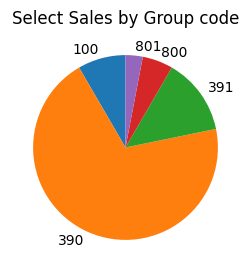

In [18]:
plt.figure(figsize=(3,3))
df_recent_select.groupby('partner_prefix')['recency'].sum().plot(kind='pie', startangle=90)
plt.title('Select Sales by Group code')
plt.ylabel('')
plt.show()

* plot histogram to view density of recent period

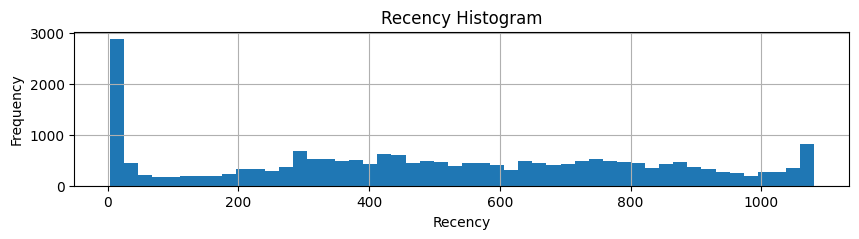

In [19]:
# plot histogram of df_recency of partrner_code
df_recent_select['recency'].hist(bins=50, figsize=(10,2))
plt.title('Recency Histogram')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()


Sales generate in each partner

In [20]:
S_table = df.groupby('partner_code').agg({'partner_code'   : lambda x:len(x),
                                         'total'  : lambda x:x.sum()})
S_table.rename(columns = {'partner_code' :'frequency',
                           'total':'sales'},inplace= True)
S_table.head()

,frequency,sales
partner_code,,
01001700,2,9
01003539,1,3
01003913,2,3
01004328,27,63
01004673,3,3


Churn subscriber from partner sales

In [21]:
# Calculate Churn Subs count(partner_code)
C_table = df.groupby('partner_code').agg({'partner_code'   : lambda x:len(x),
                                         'churn'  : lambda x:x.sum()})
C_table.rename(columns = {'partner_code' :'frequency',
                           'total':'churn'},inplace= True)
C_table.head()

,frequency,churn
partner_code,,
01001700,2,0
01003539,1,0
01003913,2,0
01004328,27,0
01004673,3,1


Revenue generate in each partner

In [22]:
R_table = df.groupby('partner_code').agg({'partner_code'   : lambda x:len(x),
                                         'revenue'  : lambda x:x.sum()})
R_table.rename(columns = {'partner_code' :'frequency',
                           'total':'revenue'},inplace= True)
R_table.head()

,frequency,revenue
partner_code,,
01001700,2,0.0
01003539,1,0.0
01003913,2,1099.0
01004328,27,0.0
01004673,3,1804.0


Invoice paid : Revenue

In [23]:
BP_table = df.groupby('partner_code').agg({'partner_code'   : lambda x:len(x),
                                         'gain'  : lambda x:x.sum()})
BP_table.rename(columns = {'partner_code' :'frequency',
                           'total':'gain'},inplace= True)
BP_table.head()

,frequency,gain
partner_code,,
01001700,2,0
01003539,1,828180
01003913,2,0
01004328,27,806306
01004673,3,0


In [24]:
merge_table = df_recent_select.merge(S_table,left_on='partner_code',right_on='partner_code') # merge select partner code with sales table
merge_table = merge_table.merge(R_table,left_on='partner_code',right_on='partner_code') # merge select partner code with revenue table
merge_table = merge_table.merge(BP_table,left_on='partner_code',right_on='partner_code') # merge select partner code with churn table

merge_table.head()

,partner_code,recency,partner_prefix,frequency_x,sales,frequency_y,revenue,frequency,gain
0,10000744,218,100,1,1,1,350.0,1,1845
1,10000749,838,100,5,6,5,2010.0,5,19251
2,10000750,831,100,1,1,1,643.0,1,938
3,10000754,737,100,1,1,1,199.0,1,2303
4,10000756,243,100,1,1,1,399.0,1,868


In [25]:
# check duplicate partner_code in merge_table
merge_table[merge_table.duplicated(['partner_code'],keep=False)]

,partner_code,recency,partner_prefix,frequency_x,sales,frequency_y,revenue,frequency,gain


In [26]:
# drop column frequency_x , frequency_y, partner_prefix in merge_table
merge_table.drop(columns=['frequency_x','frequency_y','partner_prefix'],inplace=True)
merge_table.head()

,partner_code,recency,sales,revenue,frequency,gain
0,10000744,218,1,350.0,1,1845
1,10000749,838,6,2010.0,5,19251
2,10000750,831,1,643.0,1,938
3,10000754,737,1,199.0,1,2303
4,10000756,243,1,399.0,1,868


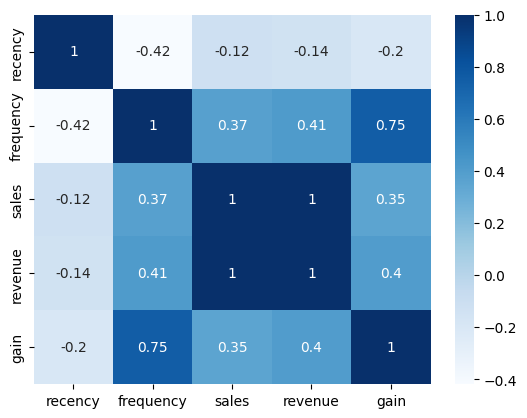

In [27]:
sns.heatmap(merge_table[['recency','frequency','sales','revenue','gain']].corr(),annot=True,cmap='Blues')
plt.show()

/var/folders/8b/h71yb7vj7b513jqfhq12rrx00000gn/T/ipykernel_4118/4270872175.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/8b/h71yb7vj7b513jqfhq12rrx00000gn/T/ipykernel_4118/4270872175.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/8b/h71yb7vj7b513jqfhq12rrx00000gn/T/ipykernel_4118/4270

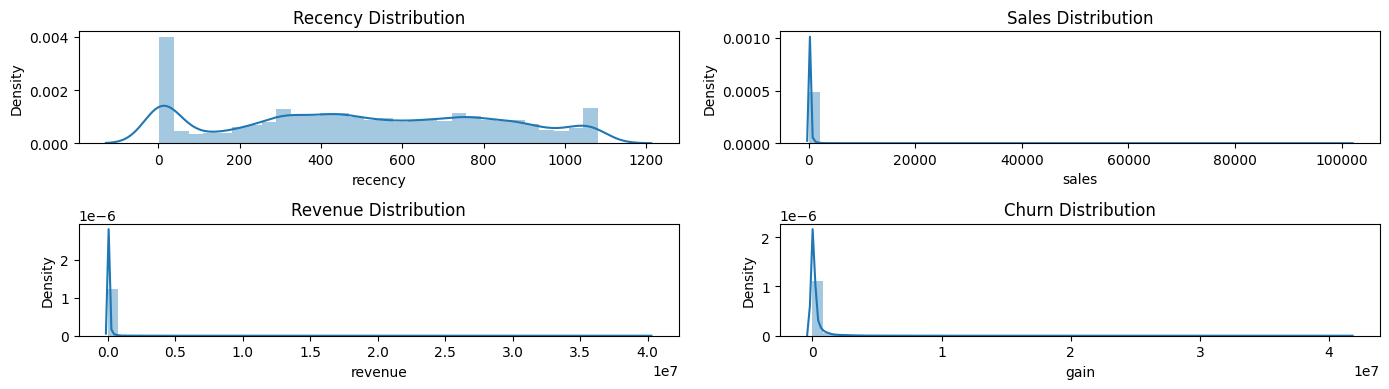

In [28]:
plt.figure(figsize=(14,4))
plt.subplot(221)
sns.distplot(merge_table["recency"])
plt.title("Recency Distribution")
plt.subplot(222)
sns.distplot(merge_table["sales"])
plt.title("Sales Distribution")
plt.subplot(223)
sns.distplot(merge_table["revenue"])
plt.title("Revenue Distribution")
plt.subplot(224)
sns.distplot(merge_table["gain"])
plt.title("Churn Distribution")
plt.tight_layout()

In [29]:
g_labels = range(1, 5)
b_labels = range(1, 5)

s_groups = np.quantile(merge_table["recency"], q=[0, .25, .5, .75, 1])
r_groups = np.quantile(merge_table["revenue"], q=[0, .25, .5, .75, 1])
c_groups = np.quantile(merge_table["gain"], q=[0, .25, .5, .75, 1])

In [30]:
merge_table["s_quartile"] = pd.cut(merge_table["recency"], bins=s_groups, labels=g_labels).astype(float) # sales quartile
merge_table["r_quartile"] = pd.cut(merge_table["revenue"], bins=r_groups, labels=g_labels).astype(float) # revenue quartile
merge_table["b_quartile"] = pd.cut(merge_table["gain"], bins=c_groups, labels=g_labels).astype(float) # bill payment quartile

In [31]:
merge_table.head()

,partner_code,recency,sales,revenue,frequency,gain,s_quartile,r_quartile,b_quartile
0,10000744,218,1,350.0,1,1845,1.0,1.0,1.0
1,10000749,838,6,2010.0,5,19251,4.0,2.0,2.0
2,10000750,831,1,643.0,1,938,4.0,1.0,1.0
3,10000754,737,1,199.0,1,2303,3.0,1.0,1.0
4,10000756,243,1,399.0,1,868,1.0,1.0,1.0


In [32]:
merge_table['Score'] = merge_table[['s_quartile','r_quartile','b_quartile']].sum(axis=1)
print(merge_table['Score'].head())

0    3.0
1    8.0
2    6.0
3    5.0
4    3.0
Name: Score, dtype: float64


In [33]:
merge_table.head()

,partner_code,recency,sales,revenue,frequency,gain,s_quartile,r_quartile,b_quartile,Score
0,10000744,218,1,350.0,1,1845,1.0,1.0,1.0,3.0
1,10000749,838,6,2010.0,5,19251,4.0,2.0,2.0,8.0
2,10000750,831,1,643.0,1,938,4.0,1.0,1.0,6.0
3,10000754,737,1,199.0,1,2303,3.0,1.0,1.0,5.0
4,10000756,243,1,399.0,1,868,1.0,1.0,1.0,3.0


In [34]:
# Define RFM level 
def level(df):
    if df['Score'] >= 8:
        return 'Perfect Partner'
    elif ((df['Score'] >= 7) and (df['Score'] < 9)):
        return 'Good Partner'
    elif ((df['Score'] >= 6) and (df['Score'] < 7)):
        return 'Potential Partner'
    elif ((df['Score'] >= 5) and (df['Score'] < 6)):
        return 'Needs Attention'
    else:
        return 'Require Activation'

In [35]:
# Create a new variable RFM_Level
merge_table['Level'] = merge_table.apply(level, axis=1)

# Print the top 5 rows 
merge_table.head()

,partner_code,recency,sales,revenue,frequency,gain,s_quartile,r_quartile,b_quartile,Score,Level
0,10000744,218,1,350.0,1,1845,1.0,1.0,1.0,3.0,Require Activation
1,10000749,838,6,2010.0,5,19251,4.0,2.0,2.0,8.0,Perfect Partner
2,10000750,831,1,643.0,1,938,4.0,1.0,1.0,6.0,Potential Partner
3,10000754,737,1,199.0,1,2303,3.0,1.0,1.0,5.0,Needs Attention
4,10000756,243,1,399.0,1,868,1.0,1.0,1.0,3.0,Require Activation


In [36]:
level_agg = merge_table.groupby('Level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'sales': ['mean', 'count']
}).round(1)

In [37]:
level_agg.head()

recency frequency  sales       
                      mean      mean   mean  count
Level                                             
Good Partner         648.2      14.0   48.1   3346
Needs Attention      427.3       5.2    6.2   1733
Perfect Partner      509.0     109.0  194.1  11368
Potential Partner    591.0       6.8    8.1   3049
Require Activation   237.4       3.5    4.0   2812

In [38]:
level_agg.dtypes

recency    mean     float64
frequency  mean     float64
sales      mean     float64
           count      int64
dtype: object

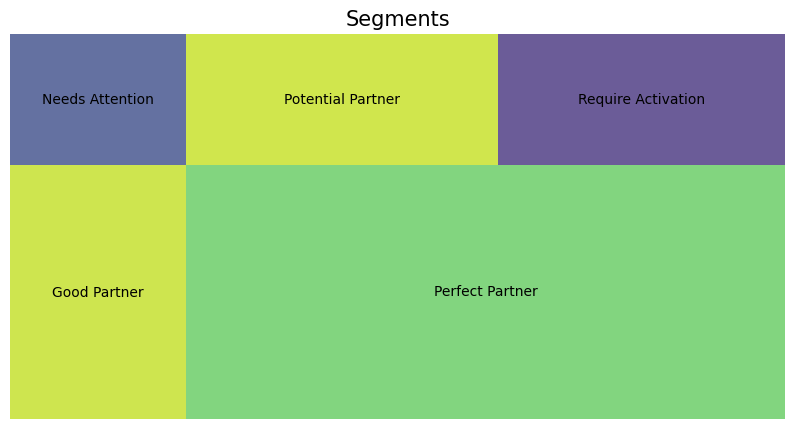

In [39]:
# plot squarify chart from level_agg
import squarify
plt.figure(figsize=(10,5))
squarify.plot(sizes=level_agg['sales']['count'], label=level_agg.index, alpha=.8 )
plt.axis('off')
plt.title("Segments",fontsize=15)
plt.show()


In [40]:
df.columns

Index(['partner_code', 'prefix', 'partner_status', 'province_eng',
       'district_en', 'sub_district_en', 'sales_date', 'register_date',
       'tm_key_day', 'total', 'revenue', 'churn', 'aging', 'paid', 'no_paid',
       'gain', 'loss', 'partner_aging', 'date', 'year', 'month', 'year_month',
       'Date'],
      dtype='object')